# import packages

In [1]:
import xgboost as xgb
import transformers as ppb  # pytorch transformers
import torch.nn as nn
import torch
import time
import string
import seaborn as sns
import re
import pickle
import pandas as pd
import os
import numpy as np
import nltk
import matplotlib.pyplot as plt
import lightgbm as lgb
import emoji
import catboost as catboost
from wordcloud import WordCloud
from transformers import BertModel
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import Dataset, TensorDataset, DataLoader, SequentialSampler, RandomSampler
from torch.nn.utils.rnn import pad_sequence
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from datetime import datetime

start_time = datetime.now()
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

# Data preprocessing

In [2]:
sc = pd.read_csv("Suicide_Detection.csv", index_col=0)

In [3]:
sc.head()

,text,class
2,Ex Wife Threatening SuicideRecently I left my ...,suicide
3,Am I weird I don't get affected by compliments...,non-suicide
4,Finally 2020 is almost over... So I can never ...,non-suicide
8,i need helpjust help me im crying so hard,suicide
9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [4]:
sc['label'] = [1 if i == 'suicide' else 0 for i in sc['class']]

## Translate emoji to English discription

In [5]:
def emoji_change(str):
    result = emoji.demojize(str, delimiters='  ')
    return result


sc['text_deemoji'] = sc['text'].apply(emoji_change)
sc

,text,class,label,text_deemoji
2,Ex Wife Threatening SuicideRecently I left my ...,suicide,1,Ex Wife Threatening SuicideRecently I left my ...
3,Am I weird I don't get affected by compliments...,non-suicide,0,Am I weird I don't get affected by compliments...
4,Finally 2020 is almost over... So I can never ...,non-suicide,0,Finally 2020 is almost over... So I can never ...
8,i need helpjust help me im crying so hard,suicide,1,i need helpjust help me im crying so hard
9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,1,"I’m so lostHello, my name is Adam (16) and I’v..."
...,...,...,...,...
348103,If you don't like rock then your not going to ...,non-suicide,0,If you don't like rock then your not going to ...
348106,You how you can tell i have so many friends an...,non-suicide,0,You how you can tell i have so many friends an...
348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide,0,pee probably tastes like salty tea smirking_fa...
348108,The usual stuff you find hereI'm not posting t...,suicide,1,The usual stuff you find hereI'm not posting t...


## Remove stopwords

In [6]:
# Remove stop_words

stop_words = set(
    stopwords.words('english') +
    [".", '.', ",", ":", "''", "'s", "'", "``", "^", "(", ")", "-"])

# Removed the stopwords
stop_removed_list = []
for line in sc['text_deemoji']:
    tokens = nltk.word_tokenize(line)
    stopword_removed = [
        token for token in tokens if token.lower() not in stop_words
    ]
    removed_sent = (" ").join(stopword_removed)
    stop_removed_list.append(removed_sent)
# append stopwords to a new column
sc['Text'] = stop_removed_list

## Regex

In [7]:
# Regex


def regex_clean(comment, ree, new):
    line = re.sub(ree, new, comment, flags=re.IGNORECASE)
    return line


re1 = r"\_"
re2 = r"filler"
re3 = r"\b(?:work[\w]+|jobs?|career|intern(ship)?|position)\b"
re4 = r"\b(?:co(\-)?worker|interpersonal|managers?|boss|supervisor|colleague|employees?|staffs?|network)\b"
sc['new_Text'] = sc['Text'].apply(regex_clean, ree=re1, new=' ')
sc['new_Text'] = sc['new_Text'].apply(regex_clean, ree=re2, new=' ')
sc['new_Text'] = sc['new_Text'].apply(regex_clean, ree=re3, new=' _WORK_ ')
sc['new_Text'] = sc['new_Text'].apply(regex_clean,
                                      ree=re4,
                                      new=' _INTERPERSONAL_ ')

## Lemmatization

In [8]:
# Lemmatization
lemmatizer = WordNetLemmatizer()


# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(
        sentence.lower()))  # I add a lower() function here since it will
    #tuple of (token, wordnet_tag)                                   # do a bad job with capital letters
    wordnet_tagged = [(x[0], nltk_tag_to_wordnet_tag(x[1]))
                      for x in nltk_tagged]
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


sc['lemm_Text'] = sc['new_Text'].apply(lemmatize_sentence)

## Topic Modeling

In [9]:
news_corpus_df = sc
news_corpus_df['text'] = sc['lemm_Text']

In [10]:
# Regex
import re


def regex_clean(comment, ree, new):
    line = re.sub(ree, new, comment, flags=re.IGNORECASE)
    return line


# Mainly for removing '_' in the English discription after translating emojis
re1 = r"\_"

# Remove noise words
re2 = r"fil(l|t)er"
re3 = r"\b(youtube)|(reddit)|(www)|(com)|(amp)|(webp)|(https)|(x200b)|(pjpg)|(format)|(png)|(auto)\b"

# Translate oral language to written language
re4 = r"\b(wan( )?na)\b"
re5 = r"\b(gon( )?na)\b"

news_corpus_df['text'] = news_corpus_df['text'].apply(regex_clean,
                                                      ree=re1,
                                                      new=' ')
news_corpus_df['text'] = news_corpus_df['text'].apply(regex_clean,
                                                      ree=re2,
                                                      new=' ')
news_corpus_df['text'] = news_corpus_df['text'].apply(regex_clean,
                                                      ree=re3,
                                                      new=' ')
news_corpus_df['text'] = news_corpus_df['text'].apply(regex_clean,
                                                      ree=re4,
                                                      new=' want ')
news_corpus_df['text'] = news_corpus_df['text'].apply(regex_clean,
                                                      ree=re5,
                                                      new=' go ')

### Bigram

In [11]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

news_vectorizer = TfidfVectorizer(ngram_range=(2, 2),
                                  min_df=0.01,
                                  max_df=0.4,
                                  stop_words="english")

X_news, news_terms = news_vectorizer.fit_transform(
    news_corpus_df.text), news_vectorizer.get_feature_names_out()

news_tf_idf = pd.DataFrame(X_news.toarray(), columns=news_terms)
print(f"News TF-IDF: {news_tf_idf.shape}")
print(news_tf_idf.head(5))

News TF-IDF: (232074, 69)
   anymore want  best friend  ca anymore  close friend   day day  die want  \
0           0.0          0.0         0.0           0.0  0.000000       0.0   
1           0.0          0.0         0.0           0.0  0.000000       0.0   
2           0.0          0.0         0.0           0.0  0.000000       0.0   
3           0.0          0.0         0.0           0.0  0.000000       0.0   
4           0.0          0.0         0.0           0.0  0.415785       0.0   

   dont know  dont want  end life  feel bad  ...  want hurt  want kill  \
0        0.0        0.0       0.0  0.000000  ...        0.0        0.0   
1        0.0        0.0       0.0  0.000000  ...        0.0        0.0   
2        0.0        0.0       0.0  0.000000  ...        0.0        0.0   
3        0.0        0.0       0.0  0.000000  ...        0.0        0.0   
4        0.0        0.0       0.0  0.378066  ...        0.0        0.0   

   want know  want live  want make  want talk  want want  we

In [12]:
nmf = NMF(n_components=2)
W_news = nmf.fit_transform(X_news)
H_news = nmf.components_
print(f"Original shape of X news is {X_news.shape}")
print(f"Decomposed W news matrix is {W_news.shape}")
print(f"Decomposed H news matrix is {H_news.shape}")
from typing import List

def get_top_tf_idf_tokens_for_topic(H: np.array,
                                    feature_names: List[str],
                                    num_top_tokens: int = 5):
    """
  Uses the H matrix (K components x M original features) to identify for each
  topic the most frequent tokens.
  """
    for topic, vector in enumerate(H):
        print(f"TOPIC {topic}\n")
        total = vector.sum()
        top_scores = vector.argsort()[::-1][:num_top_tokens]
        token_names = list(map(lambda idx: feature_names[idx], top_scores))
        strengths = list(map(lambda idx: vector[idx] / total, top_scores))

        for strength, token_name in zip(strengths, token_names):
            print(f"\b{token_name} ({round(strength * 100, 1)}%)\n")
        print(f"=" * 50)


print(f"Topics:\n\n")
get_top_tf_idf_tokens_for_topic(H_news, news_tf_idf.columns.tolist(), 10)

C:\Users\Yiyang\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Original shape of X news is (232074, 69)
Decomposed W news matrix is (232074, 2)
Decomposed H news matrix is (2, 69)
Topics:


TOPIC 0

feel like (44.9%)

make feel (3.3%)

like shit (1.6%)

life feel (1.5%)

felt like (1.5%)

know feel (1.4%)

high school (1.4%)

year ago (1.4%)

suicidal thought (1.3%)

best friend (1.2%)

TOPIC 1

want die (23.1%)

year old (6.2%)

really want (3.5%)

want kill (3.1%)

die want (2.9%)

want live (2.5%)

year ago (2.3%)

best friend (2.0%)

make feel (1.9%)

want end (1.8%)



In [13]:
def get_top_documents_for_each_topic(W: np.array,
                                     documents: List[str],
                                     num_docs: int = 5):
    sorted_docs = W.argsort(axis=0)[::-1]
    top_docs = sorted_docs[:num_docs].T
    per_document_totals = W.sum(axis=1)
    for topic, top_documents_for_topic in enumerate(top_docs):
        print(f"Topic {topic}")
        for doc in top_documents_for_topic:
            score = W[doc][topic]
            percent_about_topic = round(score / per_document_totals[doc] * 100,
                                        1)
            print(f"{percent_about_topic}%", documents[doc])
        print("=" * 50)

In [14]:
get_top_documents_for_each_topic(W_news,
                                 news_corpus_df.text.tolist(),
                                 num_docs=5)

Topic 0
100.0% ’ tire ’ even sleep feel like ’ sleep week schedule never fuck ’ awake night sleep day wake energy go back sleep ’ 3am right start go sleep midnight intrusive thought keep awake ’ sleep brain exhaust need sleep ’ ! ! !
100.0% well n't feel right wanted make post one look homepage r/teenagers post click find one someone mom die breast cancer click link  e sub 'm feel like take advantage person misery brain  work  mysterious way
100.0% ran med father diagnosed canceri know never post anything 'm  go  anything tonight omg want father n't close feel like make hard 'm really struggle right
100.0% darkness # darkness 'm swim alone pool darkness feel like darkness slowly pull yell help one hear begin see water eye level kick flail fight stay darkness darkness wo n't let go hold slowly begin give feel lie water line water start fill lung lung hold much life yet allow murky water replace know path n't lead happiness n't someone grab hand pull darkness grasp ? one know stand bound

### Trigram

In [ ]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

news_vectorizer = TfidfVectorizer(ngram_range=(3, 3),
                                  min_df=10,
                                  max_df=0.4,
                                  stop_words="english")

X_news, news_terms = news_vectorizer.fit_transform(
    news_corpus_df.text), news_vectorizer.get_feature_names_out()

news_tf_idf = pd.DataFrame(X_news.toarray(), columns=news_terms)
print(f"News TF-IDF: {news_tf_idf.shape}")
print(news_tf_idf.head(5))

News TF-IDF: (232074, 28020)
   000 000 000  000 000 billion  000 000 million  000 000 quadrillion  \
0          0.0              0.0              0.0                  0.0   
1          0.0              0.0              0.0                  0.0   
2          0.0              0.0              0.0                  0.0   
3          0.0              0.0              0.0                  0.0   
4          0.0              0.0              0.0                  0.0   

   000 000 trillion  000 billion day  000 miles away  000 million day  \
0               0.0              0.0             0.0              0.0   
1               0.0              0.0             0.0              0.0   
2               0.0              0.0             0.0              0.0   
3               0.0              0.0             0.0              0.0   
4               0.0              0.0             0.0              0.0   

   000 quadrillion day  000 student loans  ...  yr old female  yr old girl  \
0              

In [ ]:
W_news = nmf.fit_transform(X_news)
H_news = nmf.components_
print(f"Original shape of X news is {X_news.shape}")
print(f"Decomposed W news matrix is {W_news.shape}")
print(f"Decomposed H news matrix is {H_news.shape}")

/Users/yduanmu/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Original shape of X news is (232074, 28020)
Decomposed W news matrix is (232074, 2)
Decomposed H news matrix is (2, 28020)


In [ ]:
from typing import List
import numpy as np


def get_top_tf_idf_tokens_for_topic(H: np.array,
                                    feature_names: List[str],
                                    num_top_tokens: int = 5):
    """
  Uses the H matrix (K components x M original features) to identify for each
  topic the most frequent tokens.
  """
    for topic, vector in enumerate(H):
        print(f"TOPIC {topic}\n")
        total = vector.sum()
        top_scores = vector.argsort()[::-1][:num_top_tokens]
        token_names = list(map(lambda idx: feature_names[idx], top_scores))
        strengths = list(map(lambda idx: vector[idx] / total, top_scores))

        for strength, token_name in zip(strengths, token_names):
            print(f"\b{token_name} ({round(strength * 100, 1)}%)\n")
        print(f"=" * 50)


print(f"Topics:\n\n")
get_top_tf_idf_tokens_for_topic(H_news, news_tf_idf.columns.tolist(), 10)

Topics:


TOPIC 0

smiling face sunglasses (57.3%)

sunglasses smiling face (7.7%)

face sunglasses smiling (7.7%)

cool smiling face (1.4%)

face tears joy (0.7%)

face smiling face (0.6%)

face steam nose (0.6%)

backhand index pointing (0.6%)

face sunglasses thumbs (0.5%)

shit smiling face (0.4%)

TOPIC 1

loudly crying face (42.3%)

face loudly crying (11.5%)

crying face loudly (10.6%)

face tears joy (0.8%)

face pensive face (0.5%)

face rolling eyes (0.5%)

face water pistol (0.4%)

crying face want (0.4%)

face steam nose (0.4%)

pensive face pensive (0.4%)



# Model Exploration - Logistic (Baseline), Random Forest, LightGBM, XGBoost, CatBoost

## Bert Tokenizer

In [15]:
model_class, tokenizer_class, pretrained_weights = (BertModel, BertTokenizer,
                                                    'bert-base-uncased')

In [16]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights,
                                            do_lower_case=True)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
tokenized = sc['lemm_Text'].apply((lambda x: tokenizer.encode(
    x, add_special_tokens=True, padding=True, truncation=True)))

In [18]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])

In [19]:
feature_data = pd.DataFrame(np.array(padded))

In [20]:
feature_data.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,101,4654,2564,15686,5920,2890,13013,2135,2681,2564,...,0,0,0,0,0,0,0,0,0,0
1,101,6881,1050,1005,1056,2131,5360,19394,2272,2619,...,0,0,0,0,0,0,0,0,0,0
2,101,2633,12609,2471,1012,1012,1012,2196,2963,12609,...,0,0,0,0,0,0,0,0,0,0
3,101,2342,2393,29427,2393,10047,5390,2524,102,0,...,0,0,0,0,0,0,0,0,0,0
4,101,1521,2439,18223,2080,2171,4205,2385,1521,5998,...,0,0,0,0,0,0,0,0,0,0


In [21]:
scsc = sc.reset_index()

In [22]:
model_data = feature_data.join(sc)
model_data.drop([
    'text_deemoji', 'text', 'class', 'Text', 'lemm_Text', 'new_Text'
],
                axis=1,
                inplace=True)

## Train/Test Sets Split

In [23]:
X = pd.DataFrame(model_data.loc[:, [i for i in range(0, 512)]])
Y = pd.DataFrame(sc.loc[:, 'label'].reset_index()['label'])

In [24]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=.3)

## Logistic (Baseline) - Accuracy: 0.7174 (11.2s)

In [46]:
%%time
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=.3)

model = LogisticRegression()
model.fit(X_trn, Y_trn)
y_pred = model.predict(X_tst)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(Y_tst, y_pred))
print(accuracy_score(Y_tst, y_pred))

C:\Users\Yiyang\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[27194  7531]
 [12145 22753]]
0.7173922410697614
CPU times: total: 9.81 s
Wall time: 11.2 s


C:\Users\Yiyang\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## XGBoost - Accuracy: 0.8545 (56.8s)

In [66]:
%%time
#XGB

X_trn, X_tst, Y_trn, Y_tst = train_test_split(X, Y, test_size=.3)

model = xgb.XGBClassifier()
model.fit(X_trn, Y_trn)
y_pred = model.predict(X_tst)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(Y_tst, y_pred))
print(accuracy_score(Y_tst, y_pred))

[[30317  4514]
 [ 5617 29175]]
0.8544877411200321
CPU times: total: 7min 29s
Wall time: 56.8 s


## RNN - Accuracy: 0.9493 (7min38s)

In [26]:
vocab_size = tokenizer.vocab_size

print("Vocabulary size:", vocab_size)

Vocabulary size: 30522


In [27]:
# simple sentiment analysis
# first we need to pad the sequences so that they have the same length
# get reproducible results
from numpy.random import seed
seed(0xdeadbeef)
import tensorflow as tf
tf.random.set_seed(0xdeadbeef)
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, Dense
from keras.utils import pad_sequences
from tensorflow.keras import layers

# adding an embedding layer
model = keras.Sequential()

# the first layer is the embedding layer. 
# we indicate the number of possible words, the dimension of the embedding space, and the maximum size of the text. 
model.add(keras.layers.Embedding(vocab_size, 128, input_length=max_len))
# the output of the embedding is multidimensional, with shape (256, 2)
# for each word, we obtain two values, the x and y coordinates
# we flatten this output to be able to use it in a dense layer
model.add(keras.layers.Flatten())
# dropout regularization
model.add(keras.layers.Dropout(rate=0.5))
# small dense layer. It's role is to analyze the distribution of points from embedding
model.add(keras.layers.Dense(50))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 128)          3906816   
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dropout (Dropout)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 50)                3276850   
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7,183,717
Trainable params: 7,183,717
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
1016/1016 [==============================] - 92s 90ms/step - loss: 0.2060 - accuracy: 0.9255 - val_loss: 0.1453 - val_accuracy: 0.9486
Epoch 2/10
1016/1016 [==============================] - 91s 90ms/step - loss: 0.1198 - accuracy: 0.9569 - val_loss: 0.1474 - val_accuracy: 0.9437
Epoch 3/10
1016/1016 [==============================] - 93s 91ms/step - loss: 0.0968 - accuracy: 0.9660 - val_loss: 0.1439 - val_accuracy: 0.9496
Epoch 4/10
1016/1016 [==============================] - 91s 90ms/step - loss: 0.0802 - accuracy: 0.9721 - val_loss: 0.1511 - val_accuracy: 0.9480
Epoch 5/10
1016/1016 [==============================] - 89s 88ms/step - loss: 0.0678 - accuracy: 0.9764 - val_loss: 0.1559 - val_accuracy: 0.9487


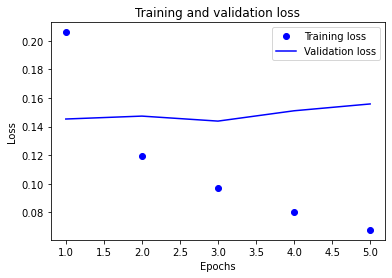

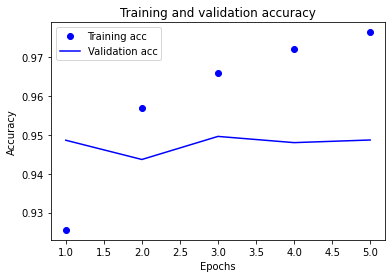

CPU times: total: 5min 17s
Wall time: 7min 37s


In [28]:
%%time
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]

history = model.fit(X_trn, Y_trn,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2, callbacks=callbacks_list)

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [29]:
model = keras.models.load_model("checkpoint_path.keras")
model.evaluate(X_tst, Y_tst)

2176/2176 [==============================] - 11s 5ms/step - loss: 0.1455 - accuracy: 0.9493


[0.14548911154270172, 0.9493127465248108]

## Bidirectional GRU - Accuracy: 0.9649 (2h40min)

In [30]:
inputs = tf.keras.Input(shape=(None,), dtype='int32')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         3906816   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               31104     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                             

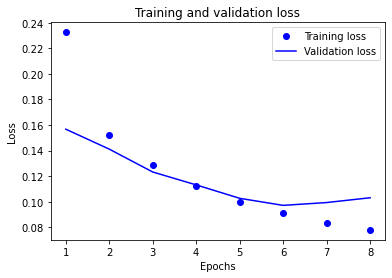

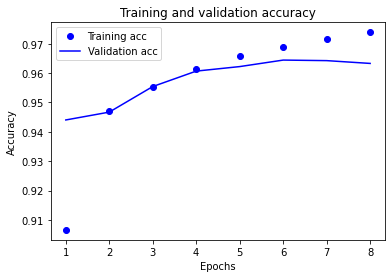

In [31]:

x = tf.keras.layers.Embedding(vocab_size, 128)(inputs)
x = layers.Bidirectional(layers.GRU(32,recurrent_dropout=0.5, dropout=0.4))(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]



history = model.fit(X_trn, Y_trn,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2, callbacks=callbacks_list)

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [32]:
model = keras.models.load_model("checkpoint_path.keras")
model.evaluate(X_tst, Y_tst)

2176/2176 [==============================] - 101s 46ms/step - loss: 0.0983 - accuracy: 0.9649


[0.09829404205083847, 0.9649110436439514]

# Model Exploration - Bert

## Check GPU

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Train/Validation Sets Split

In [34]:
df = sc
train_df, val_df = train_test_split(df,
                                    test_size=0.3,
                                    stratify=df.label,
                                    random_state=42)

In [35]:
train_df=  train_df.loc[:, ['label', 'lemm_Text']]
val_df=  val_df.loc[:, ['label', 'lemm_Text']]

## Define BertTokenizer and Data loader (Set truncation for long text)

In [57]:
class MNLIDataBert(Dataset):
    def __init__(self, train_df, val_df):
        self.label_dict = {0: 0, 1: 1}

        self.train_df = train_df
        self.val_df = val_df

        self.base_path = '/content/'
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                                       do_lower_case=True,
                                                       truncation=True)
        self.train_data = None
        self.val_data = None
        self.init_data()

    def init_data(self):
        # Saving takes too much RAM
        #
        # if os.path.exists(os.path.join(self.base_path, 'train_data.pkl')):
        #   print("Found training data")
        #   with open(os.path.join(self.base_path, 'train_data.pkl'), 'rb') as f:
        #     self.train_data = pickle.load(f)
        # else:
        #   self.train_data = self.load_data(self.train_df)
        #   with open(os.path.join(self.base_path, 'train_data.pkl'), 'wb') as f:
        #     pickle.dump(self.train_data, f)
        # if os.path.exists(os.path.join(self.base_path, 'val_data.pkl')):
        #   print("Found val data")
        #   with open(os.path.join(self.base_path, 'val_data.pkl'), 'rb') as f:
        #     self.val_data = pickle.load(f)
        # else:
        #   self.val_data = self.load_data(self.val_df)
        #   with open(os.path.join(self.base_path, 'val_data.pkl'), 'wb') as f:
        #     pickle.dump(self.val_data, f)
        self.train_data = self.load_data(self.train_df)
        self.val_data = self.load_data(self.val_df)

    def load_data(self, df):
        MAX_LEN = 50
        token_ids = []
        mask_ids = []
        seg_ids = []
        y = []

        premise_list = df['lemm_Text'].to_list()
        label_list = df['label'].to_list()

        for (premise, label) in zip(premise_list, label_list):
            premise_id = self.tokenizer.encode(premise,
                                               add_special_tokens=True,
                                               truncation=True,
                                               max_length=50)
            pair_token_ids = [self.tokenizer.cls_token_id
                              ] + premise_id + [self.tokenizer.sep_token_id]
            premise_len = len(premise_id)

            segment_ids = torch.tensor(
                [0] * (premise_len + 2))  # sentence 0 and sentence 1
            attention_mask_ids = torch.tensor(
                [1] * (premise_len + 2))  # mask padded values

            token_ids.append(torch.tensor(pair_token_ids))
            seg_ids.append(segment_ids)
            mask_ids.append(attention_mask_ids)
            y.append(self.label_dict[label])

        token_ids = pad_sequence(token_ids, batch_first=True)
        mask_ids = pad_sequence(mask_ids, batch_first=True)
        seg_ids = pad_sequence(seg_ids, batch_first=True)
        y = torch.tensor(y)
        dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
        print((len(dataset)))
        return dataset

    def get_data_loaders(self, batch_size=8, shuffle=True):
        train_loader = DataLoader(self.train_data,
                                  shuffle=shuffle,
                                  batch_size=batch_size)

        val_loader = DataLoader(self.val_data,
                                shuffle=shuffle,
                                batch_size=batch_size)

        return train_loader, val_loader

In [58]:
mnli_dataset = MNLIDataBert(train_df, val_df)

162451
69623


In [59]:
train_loader, val_loader = mnli_dataset.get_data_loaders(batch_size=32)

## Load Bert from pretrained

In [60]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=2)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Parameters

In [61]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{
    'params':
    [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.01
}, {
    'params':
    [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.0
}]

## Optimizer - AdamW

In [62]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, correct_bias=False)

C:\Users\Yiyang\Anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Number of Trainable Parameters - 109,483,778

In [63]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 109,483,778 trainable parameters


## Define train and evaluation functions

In [64]:
def multi_acc(y_pred, y_test):
    acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1)
           == y_test).sum().float() / float(y_test.size(0))
    return acc

In [68]:
# criterion = nn.CrossEntropyLoss().to(device)
EPOCHS = 3


def train(model, train_loader, val_loader, optimizer):
    total_step = len(train_loader)

    for epoch in range(EPOCHS):
        start = time.time()
        model.train()
        total_train_loss = 0
        total_train_acc = 0
        for batch_idx, (pair_token_ids, mask_ids, seg_ids,
                        y) in enumerate(train_loader):
            optimizer.zero_grad()
            pair_token_ids = pair_token_ids.to(device)
            mask_ids = mask_ids.to(device)
            seg_ids = seg_ids.to(device)
            labels = y.to(device)
            # prediction = model(pair_token_ids, mask_ids, seg_ids)
            loss, prediction = list(
                model(pair_token_ids,
                      token_type_ids=seg_ids,
                      attention_mask=mask_ids,
                      labels=labels).values())

            # loss = criterion(prediction, labels.view(-1, 1))
            acc = multi_acc(prediction, labels)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_acc += acc.item()

        train_acc = total_train_acc / len(train_loader)
        train_loss = total_train_loss / len(train_loader)
        model.eval()
        total_val_acc = 0
        total_val_loss = 0
        with torch.no_grad():
            for batch_idx, (pair_token_ids, mask_ids, seg_ids,
                            y) in enumerate(val_loader):
                optimizer.zero_grad()
                pair_token_ids = pair_token_ids.to(device)
                mask_ids = mask_ids.to(device)
                seg_ids = seg_ids.to(device)
                labels = y.to(device)

                # prediction = model(pair_token_ids, mask_ids, seg_ids)
                loss, prediction = list(
                    model(pair_token_ids,
                          token_type_ids=seg_ids,
                          attention_mask=mask_ids,
                          labels=labels).values())

                # loss = criterion(prediction, labels.view(-1, 1))
                acc = multi_acc(prediction, labels)

                total_val_loss += loss.item()
                total_val_acc += acc.item()

        val_acc = total_val_acc / len(val_loader)
        val_loss = total_val_loss / len(val_loader)
        end = time.time()
        hours, rem = divmod(end - start, 3600)
        minutes, seconds = divmod(rem, 60)

        print(
            f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}'
        )
        print(("{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes),
                                               seconds)))

## Result - Accuracy 97.4% (28 min 23 s)

In [ ]:
train(model, train_loader, val_loader, optimizer)

Epoch 1: train_loss: 0.1015 train_acc: 0.9620 | val_loss: 0.0754 val_acc: 0.9740
00:28:23.19
Epoch 2: train_loss: 0.0511 train_acc: 0.9817 | val_loss: 0.0768 val_acc: 0.9724
00:28:22.07
Epoch 3: train_loss: 0.0274 train_acc: 0.9906 | val_loss: 0.0907 val_acc: 0.9713
00:28:22.96


**BERT code reference**: https://github.com/dh1105/Sentence-Entailment/blob/main/Sentence_Entailment_BERT.ipynb